# Data Processing with `geoPFA`: 3D Example from Newberry Volcano, OR
This tutorial demonstrates how to use the **data processing workflow** in `geoPFA`.  
You’ll learn how to:

1. Load a PFA configuration file (which defines criteria, components, and layers)
2. Read raw geospatial datasets into the working `pfa` dictionary
3. Process and clean these datasets into a consistent grid ready for layer combination and favorability modeling

Subsequent notebooks will build upon this by combining layers, applying weights, and producing final favorability models.

## 1. Imports and Setup

In [1]:
# --- General imports ---
from pathlib import Path
import numpy as np
import geopandas as gpd

# --- geoPFA core classes ---
from geoPFA.data_readers import GeospatialDataReaders
from geoPFA.processing import Cleaners, Processing
from geoPFA.geopfa3d.plotters import GeospatialDataPlotters  # TODO: change to geoPFA.plotters

# --- Utilities ---
from rex.utilities.utilities import safe_json_load

### Define Project Paths


In [2]:
# Get the directory where this notebook lives
notebook_dir = Path(__file__).resolve().parent if "__file__" in locals() else Path.cwd()

# Define the main project directory (where 'config/', 'data/', and 'notebooks/' live)
project_dir = notebook_dir.parent

# Define subdirectories
config_dir = project_dir / "config"
data_dir = project_dir / "data"

# Confirm structure
print("Notebook directory:", notebook_dir)
print("Config directory:", config_dir)
print("Data directory:", data_dir)

# Quick check before proceeding
for folder in [config_dir, data_dir]:
    if not folder.exists():
        raise FileNotFoundError(f"Expected folder not found: {folder}")

Notebook directory: c:\Users\smello\Documents\geoPFA\examples\Newberry\3D\notebooks
Config directory: c:\Users\smello\Documents\geoPFA\examples\Newberry\3D\config
Data directory: c:\Users\smello\Documents\geoPFA\examples\Newberry\3D\data


## 2. Reading Input Data
With the project directories defined, the next step is to **read the configuration file** and **load all raw geospatial data** into memory.

Each PFA project is organized according to a hierarchy of criteria → components → layers, where each **layer** represents a dataset.  

The configuration JSON defines:
- Which layers belong to which components and criteria  
- File names, coordinate reference systems (CRS), and column definitions  
- Processing instructions (e.g., interpolation methods, z-measure units)

To ensure a smooth workflow:
- Folder names and file names under `/data` must exactly match those specified in the JSON.  
- Each dataset must have consistent column names and units with its config entry.  

### Read configuration file

In [3]:
# Path to configuration file
pfa_path = config_dir / "newberry_superhot_config.json"

# Load JSON configuration safely (handles comments and malformed JSON)
pfa = safe_json_load(str(pfa_path))

# Quick check
if not pfa_path.exists():
    raise FileNotFoundError(f"Configuration file not found: {pfa_path}")

pfa = safe_json_load(str(pfa_path))
print(f"Loaded PFA configuration from: {pfa_path}")

Loaded PFA configuration from: c:\Users\smello\Documents\geoPFA\examples\Newberry\3D\config\newberry_superhot_config.json


### Load data into the `pfa` dictionary

In [4]:
# Define the file types to be read (others will be skipped with a warning)
file_types = [".csv", ".shp"]

# Gather data according to the config structure
pfa = GeospatialDataReaders.gather_data(data_dir, pfa, file_types)

criteria: geologic
	 component: heat
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: temperature_model_500m
		 reading layer: velocity_model_vp
		 reading layer: velocity_model_vs
		 reading layer: velocity_model_vpvs
		 reading layer: earthquakes
	 component: producibility
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: velocity_model_vp
		 reading layer: velocity_model_vs
		 reading layer: velocity_model_vpvs
		 reading layer: earthquakes
		 reading layer: faults_3d
	 component: insulation
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: velocity_model_vp
		 reading layer: earthquakes


### Verify that all layers loaded correctly
This simple diagnostic ensures that each layer entry in the `pfa` dictionary contains a `"data"` key with a valid GeoDataFrame.

In [5]:
missing_data_layers = []

for criteria, crit_data in pfa.get("criteria", {}).items():
    for component, comp_data in crit_data.get("components", {}).items():
        for layer, layer_data in comp_data.get("layers", {}).items():
            if "data" not in layer_data:
                missing_data_layers.append({
                    "criteria": criteria,
                    "component": component,
                    "layer": layer,
                })

if missing_data_layers:
    print("Layers missing 'data':")
    for item in missing_data_layers:
        print(f" - {item['criteria']} / {item['component']} / {item['layer']}")
else:
    print("All layers contain 'data'.")

All layers contain 'data'.


## 3. Harmonizing Coordinate Systems, Elevations, and Extents

Now that all raw layers are loaded into the `pfa` dictionary, we’ll:
- Define a target coordinate reference system (CRS)
- Set a consistent vertical reference (z-measurement)
- Derive a shared spatial extent for clipping and gridding
- Preview the input data layers

### Define the Target CRS and Project Boundary

In [6]:
# EPSG code for UTM Zone 10N (meters)
target_crs = 26910

# Load the project boundary shapefile
outline_path = data_dir / "supporting_data" / "national_monument_boundary" / "NNVM_bounds.shp"
outline = gpd.read_file(outline_path).to_crs(target_crs)

print(f"Loaded boundary: {outline_path.name}")

Loaded boundary: NNVM_bounds.shp


### Standardize Z-Measurements
Many datasets reference elevation differently.
To ensure proper 3-D alignment, we’ll convert all layers to a common vertical datum.

In [7]:
target_z_meas = "m-msl"

for criteria, crit_data in pfa["criteria"].items():
    print(criteria)
    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")
        for layer, layer_data in comp_data["layers"].items():
            gdf = layer_data["data"]
            z_meas = layer_data["z_meas"]

            if target_z_meas != z_meas:
                print(f"\t\t{layer}: converting from {z_meas} → {target_z_meas}")
                print(f"\t\tmin z: {gdf.geometry.z.min():.1f}, max z: {gdf.geometry.z.max():.1f}")

                converted = Cleaners.convert_z_measurements(gdf, z_meas, target_z_meas)
                pfa["criteria"][criteria]["components"][component]["layers"][layer]["data"] = converted

geologic
	heat
		temperature_model_500m: converting from epsg:26910 → m-msl
		min z: -9950.0, max z: 2550.0
epsg:26910 26910
successful import
CoordinateTransformation created


c:\Users\smello\AppData\Local\anaconda3\envs\geopfa\Lib\site-packages\osgeo\osr.py:424: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


		velocity_model_vp: converting from epsg:26910 → m-msl
		min z: -3634.2, max z: 2383.6
epsg:26910 26910
successful import
CoordinateTransformation created
		velocity_model_vs: converting from epsg:26910 → m-msl
		min z: -3634.2, max z: 2383.6
epsg:26910 26910
successful import
CoordinateTransformation created
		velocity_model_vpvs: converting from epsg:26910 → m-msl
		min z: -3634.2, max z: 2383.6
epsg:26910 26910
successful import
CoordinateTransformation created
		earthquakes: converting from epsg:26910 → m-msl
		min z: -23400.0, max z: 1991.0
epsg:26910 26910
successful import
CoordinateTransformation created
	producibility
		velocity_model_vp: converting from epsg:26910 → m-msl
		min z: -3634.2, max z: 2383.6
epsg:26910 26910
successful import
CoordinateTransformation created
		velocity_model_vs: converting from epsg:26910 → m-msl
		min z: -3634.2, max z: 2383.6
epsg:26910 26910
successful import
CoordinateTransformation created
		velocity_model_vpvs: converting from epsg:26910 → 

### Unify CRS and Define Extent

In [8]:
# Reproject all layers to the target CRS
pfa = Cleaners.set_crs(pfa, target_crs=target_crs)

# Choose one representative layer to define the spatial extent
extent_layer = (
    pfa["criteria"]["geologic"]["components"]["heat"]["layers"]["mt_resistivity_joint_inv"]["data"]
)
extent = Cleaners.get_extent_3d(extent_layer)

# Manually adjust z-extent for this project (meters)
extent[2] = np.float64(-6000)

# Validate the extent
print(f"Extent: {extent}")
if extent[0] >= extent[3] or extent[1] >= extent[4] or extent[2] >= extent[5]:
    raise ValueError("Invalid extent: min values must be less than max values.")

# Define the active criterion (geologic only in this example)
criteria = "geologic"

Extent: [np.float64(624790.891073), np.float64(4825350.71118), np.float64(-6000.0), np.float64(653145.891073), np.float64(4855310.71118), np.float64(2379.88418165)]


### Visualize Raw Data Layers
#### Plot a Single Layer

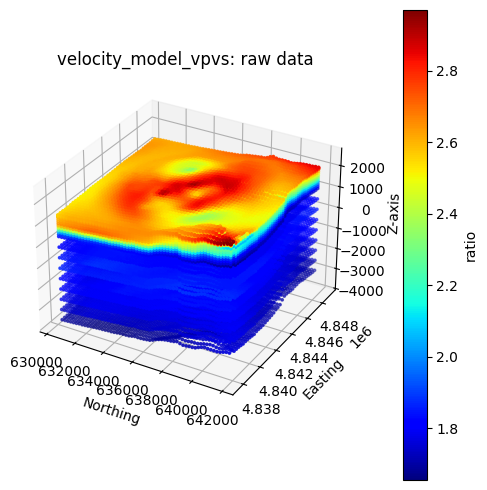

In [9]:
component = "heat"
layer = "velocity_model_vpvs"

gdf = pfa["criteria"][criteria]["components"][component]["layers"][layer]["data"]
col = pfa["criteria"][criteria]["components"][component]["layers"][layer]["data_col"]
units = pfa["criteria"][criteria]["components"][component]["layers"][layer]["units"]
title = f"{layer}: raw data"

GeospatialDataPlotters.geo_plot_3d(gdf, col, units, title, markersize=3, figsize=(5, 5))

#### Plot All Layers (Optional)

Loop through the full hierarchy and visualize every dataset.
This is useful for verifying that CRS, units, and extents align, but can take time for large inputs.

geologic
	heat


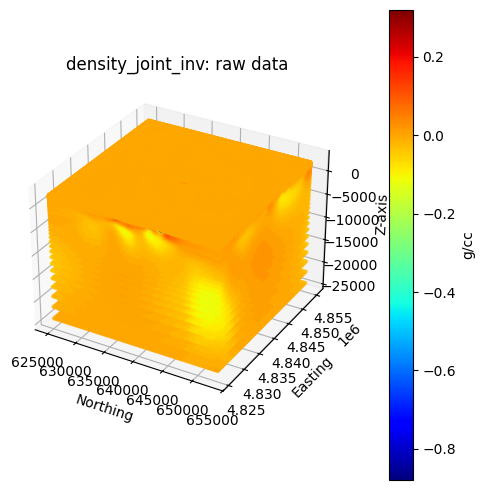

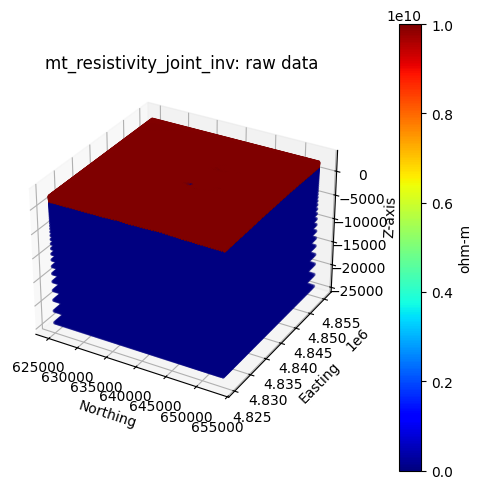

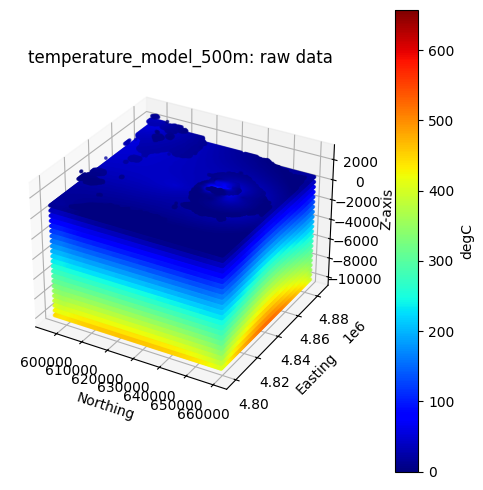

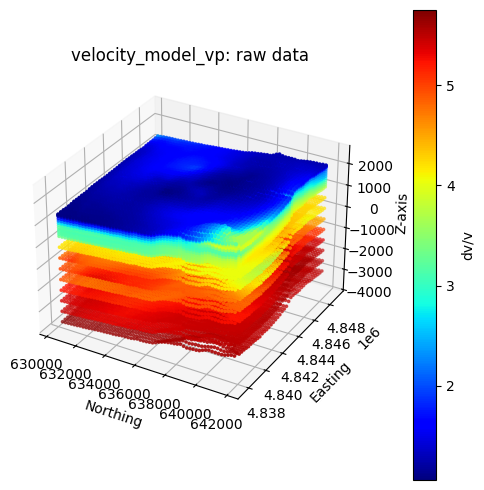

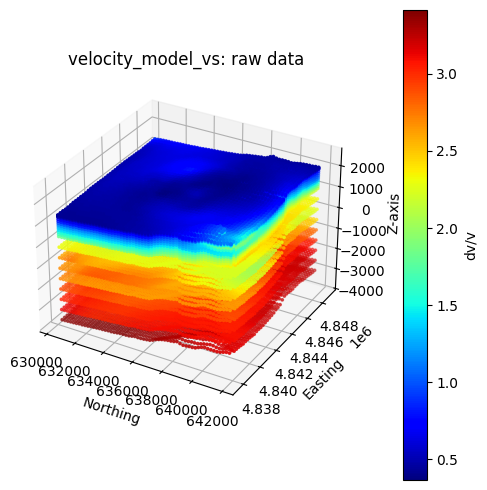

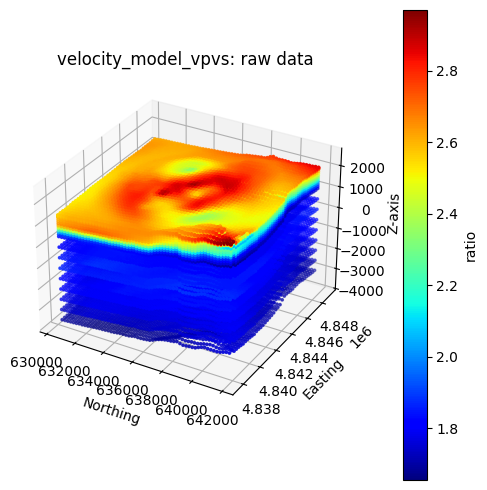

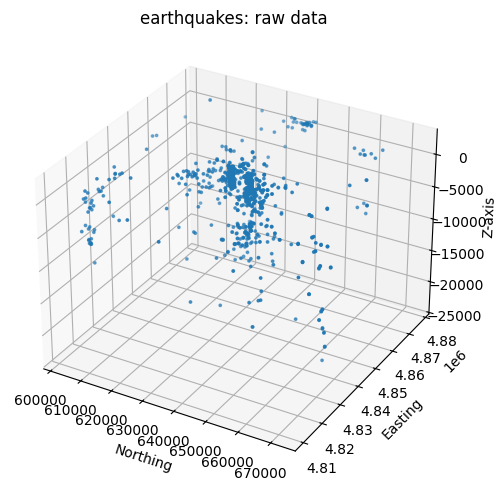

	producibility
		density_joint_inv plotted already
		mt_resistivity_joint_inv plotted already
		velocity_model_vp plotted already
		velocity_model_vs plotted already
		velocity_model_vpvs plotted already
		earthquakes plotted already


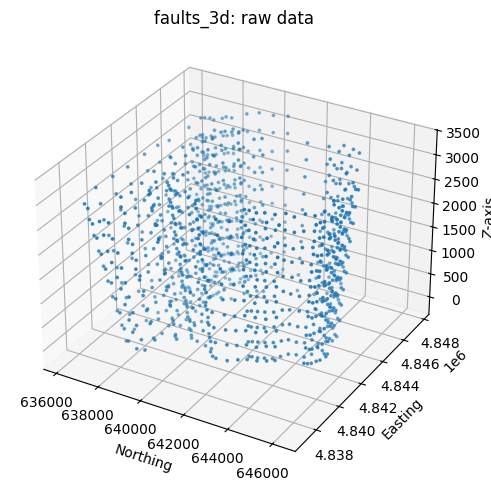

	insulation
		density_joint_inv plotted already
		mt_resistivity_joint_inv plotted already
		velocity_model_vp plotted already
		earthquakes plotted already


In [10]:
for criteria, crit_data in pfa["criteria"].items():
    print(criteria)
    plotted_layers = []
    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")
        for layer, layer_data in comp_data["layers"].items():
            if layer in plotted_layers:
                print(f"\t\t{layer} plotted already")
                continue

            gdf = layer_data["data"]
            col = layer_data.get("data_col", None)
            if layer == "faults":
                col = None  # faults are geometries only

            units = layer_data["units"]
            title = f"{layer}: raw data"

            GeospatialDataPlotters.geo_plot_3d(gdf, col, units, title, markersize=3, figsize=(5, 5))
            plotted_layers.append(layer)

## 4. Data Processing and Preparation
This step transforms raw geospatial inputs into standardized layers on a shared 3D grid for comparison and combination.

Examples:
- *Permeability indicators*: distance to faults, earthquake density  
- *Heat indicators*: resistivity, temperature, low density  
- *Insulation indicators*: shallow resistivity, seismic velocity  

Processing ensures all layers:
- Are free from outliers  
- Share the same CRS and spatial extent  
- Are mapped to the same `(nx, ny, nz)` grid  
- Represent physical meaning consistently  

---

### How It Works

All `geoPFA` processing functions follow the same pattern:

1. Take the **raw input** stored in  
   `pfa["criteria"][criteria]["components"][component]["layers"][layer]["data"]`
2. Process it (e.g., interpolation, point density, distance-to-feature)  
   onto the common 3D grid
3. Write the result to  
   `pfa["criteria"][criteria]["components"][component]["layers"][layer]["model"]`


### Log Transform Resistivity
Resistivity values typically span several orders of magnitude; using a logarithmic transform linearizes their distribution.

In [11]:
for comp in ["heat", "producibility", "insulation"]:
    gdf = pfa["criteria"]["geologic"]["components"]["heat"]["layers"]["mt_resistivity_joint_inv"]["data"].copy()
    col = pfa["criteria"]["geologic"]["components"]["heat"]["layers"]["mt_resistivity_joint_inv"]["data_col"]
    gdf[col] = np.log(gdf[col])
    pfa["criteria"]["geologic"]["components"][comp]["layers"]["mt_resistivity_joint_inv"]["data"] = gdf
    pfa["criteria"]["geologic"]["components"][comp]["layers"]["mt_resistivity_joint_inv"]["units"] = "log(ohm-m)"

### Filter Outliers
Some datasets contain spurious extreme values.
Use Cleaners.filter_geodataframe() to remove these outliers based on a quantile threshold.

In [12]:
# Filter the upper 10% of values in selected datasets
target_layers = ["velocity_model_vs", "velocity_model_vp", "velocity_model_vpvs"]

for layer in target_layers:
    for component in ["heat", "producibility"]:
        gdf = pfa["criteria"][criteria]["components"]["heat"]["layers"][layer]["data"]
        col = pfa["criteria"][criteria]["components"]["heat"]["layers"][layer]["data_col"]

        filtered = Cleaners.filter_geodataframe(gdf, col, quantile=0.9)
        pfa["criteria"][criteria]["components"][component]["layers"][layer]["data"] = filtered

print("✅ Outlier filtering complete.")

✅ Outlier filtering complete.


C:\Users\smello\Documents\geoPFA\geoPFA\processing.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[series > q] = q
C:\Users\smello\Documents\geoPFA\geoPFA\processing.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[series > q] = q
C:\Users\smello\Documents\geoPFA\geoPFA\processing.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[series > q] = q
C:\Users\smello\Documents\geoPFA\geoPFA\pro

> **Optional Step: Interpolation**
>
> Interpolation can take a long time for large datasets and fine 3D grids (30–90+ minutes).  
> For the purposes of this tutorial, users may **skip** this section and instead use the preprocessed data
> included in the example files.  
>
> If you skip interpolation:
> - Layers that normally require interpolation will **not** have a `"model"` entry in the `pfa` dictionary.
> - These layers cannot be plotted or combined until you load preprocessed versions (next notebook).

In [13]:
# Define grid resolution (number of cells in x, y, z)
nx = 50; ny = 50; nz = 25

method = 'linear'

interpolated_layers = {}

for criteria, crit_data in pfa["criteria"].items():
    print(criteria)
    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")
        for layer, layer_config in comp_data["layers"].items():
            if layer_config.get("processing_method") == "interpolate":
                if layer in interpolated_layers:
                    print(f"\t\tReusing cached interpolation for {layer}")
                    pfa["criteria"][criteria]["components"][component]["layers"][layer] = (
                        interpolated_layers[layer].copy()
                    )
                else:
                    print(f"\t\tInterpolating layer: {layer}")
                    pfa = Processing.interpolate_points_3d(
                        pfa,
                        criteria=criteria,
                        component=component,
                        layer=layer,
                        nx=nx,
                        ny=ny,
                        nz=nz,
                        extent=extent,
                    )
                    interpolated_layers[layer] = (
                        pfa["criteria"][criteria]["components"][component]["layers"][layer].copy()
                    )


geologic
	heat
		Interpolating layer: density_joint_inv
Grid resolution: 50 x 50 x 25


KeyboardInterrupt: 

### Point Density to be Used as a Favorability Proxy

For some layers, the spatial density of points (e.g., earthquake occurrences) is an indicator of permeability or fracturing.
Use Processing.point_density_3d_projected() to compute 3D density grids.

In [14]:
cell_size_x = 2500
cell_size_y = 2500
cell_size_z = 1000

print(f"cell sizes (m): {cell_size_x}, {cell_size_y}, {cell_size_z}")

# Compute 3D density for earthquake points across components
for comp in ["heat", "producibility", "insulation"]:
    pfa = Processing.point_density_3d_projected(
        pfa,
        criteria="geologic",
        component=comp,
        layer="earthquakes",
        extent=extent,
        cell_size_x=cell_size_x,
        cell_size_y=cell_size_y,
        cell_size_z=cell_size_z,
        nx=nx,
        ny=ny,
        nz=nz,
    )

# Filter extreme densities
for comp in ["heat", "producibility", "insulation"]:
    gdf = pfa["criteria"]["geologic"]["components"][comp]["layers"]["earthquakes"]["model"]
    col = pfa["criteria"]["geologic"]["components"][comp]["layers"]["earthquakes"]["model_data_col"]
    filtered = Cleaners.filter_geodataframe(gdf, col, quantile=0.99)
    pfa["criteria"]["geologic"]["components"][comp]["layers"]["earthquakes"]["model"] = filtered


cell sizes (m): 2500, 2500, 1000


C:\Users\smello\Documents\geoPFA\geoPFA\processing.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[series > q] = q
C:\Users\smello\Documents\geoPFA\geoPFA\processing.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[series > q] = q
C:\Users\smello\Documents\geoPFA\geoPFA\processing.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[series > q] = q


#### Visualize Earthquake Density
Only plot grids with density greater than 0.

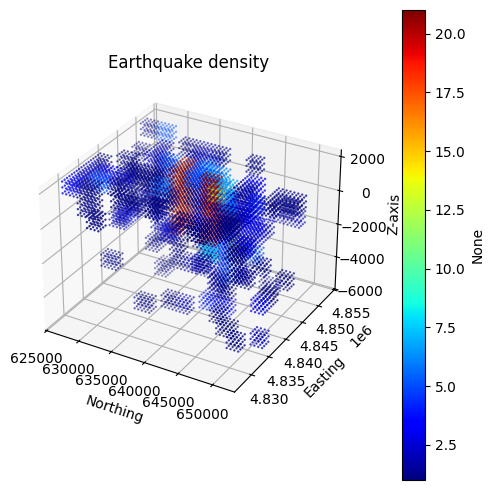

In [15]:
gdf = pfa["criteria"]["geologic"]["components"]["producibility"]["layers"]["earthquakes"]["model"]
gdf = gdf[gdf["density"] > 0]
GeospatialDataPlotters.geo_plot_3d(gdf, "density", "None", "Earthquake density", extent=extent, markersize=0.5, figsize=(5, 5))

### Distance to Faults
Faults often serve as permeability pathways.
We first convert fault points into surfaces, then compute 3D distance from those solids.

In [16]:
# Generate fault surfaces from point clusters
gdf_points = pfa["criteria"]["geologic"]["components"]["producibility"]["layers"]["faults_3d"]["data"]
fault_number_col = "Fault_Number"  # Column in original data file. This ensure faults
pfa["criteria"]["geologic"]["components"]["producibility"]["layers"]["faults_3d"]["data"] = (
    Processing.create_fault_surfaces_from_points(gdf_points, fault_number_col)
)

# Calculate 3D distance to fault surfaces
pfa = Processing.distance_from_3d_solids(
    pfa,
    criteria="geologic",
    component="producibility",
    layer="faults_3d",
    extent=extent,
    nx=nx,
    ny=ny,
    nz=nz,
)

#### Visualize Fault Distance
Slice plot in the x direction to better observe the distance function.

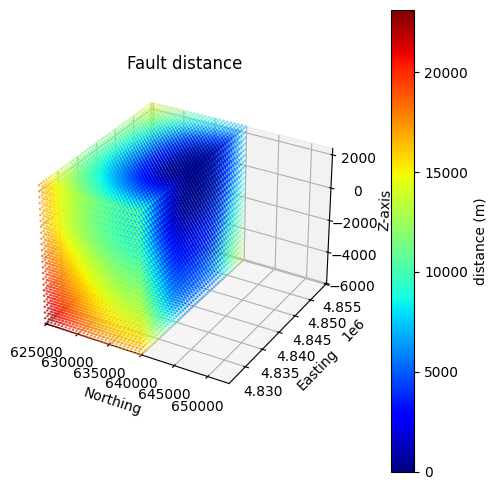

In [17]:
gdf = pfa["criteria"]["geologic"]["components"]["producibility"]["layers"]["faults_3d"]["model"]
col = pfa["criteria"]["geologic"]["components"]["producibility"]["layers"]["faults_3d"]["model_data_col"]

GeospatialDataPlotters.geo_plot_3d(gdf, col, "distance (m)", "Fault distance", extent=extent,
                                   markersize=0.5, figsize=(5,5), x_slice=640000)

### Plot All Processed Layers

geologic
	heat
		⚠️ Skipping density_joint_inv: no processed 'model' found (likely not interpolated).
		⚠️ Skipping mt_resistivity_joint_inv: no processed 'model' found (likely not interpolated).
		⚠️ Skipping temperature_model_500m: no processed 'model' found (likely not interpolated).
		⚠️ Skipping velocity_model_vp: no processed 'model' found (likely not interpolated).
		⚠️ Skipping velocity_model_vs: no processed 'model' found (likely not interpolated).
		⚠️ Skipping velocity_model_vpvs: no processed 'model' found (likely not interpolated).


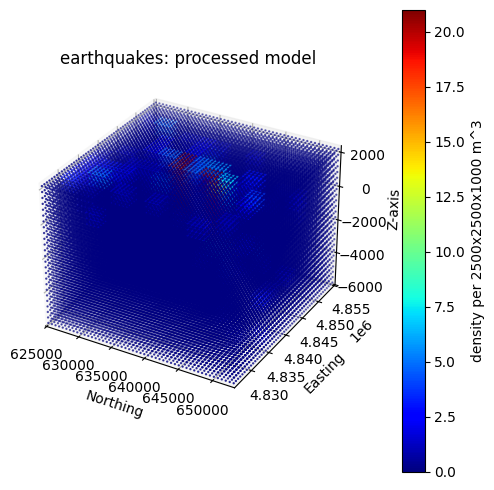

	producibility
		⚠️ Skipping density_joint_inv: no processed 'model' found (likely not interpolated).
		⚠️ Skipping mt_resistivity_joint_inv: no processed 'model' found (likely not interpolated).
		⚠️ Skipping velocity_model_vp: no processed 'model' found (likely not interpolated).
		⚠️ Skipping velocity_model_vs: no processed 'model' found (likely not interpolated).
		⚠️ Skipping velocity_model_vpvs: no processed 'model' found (likely not interpolated).


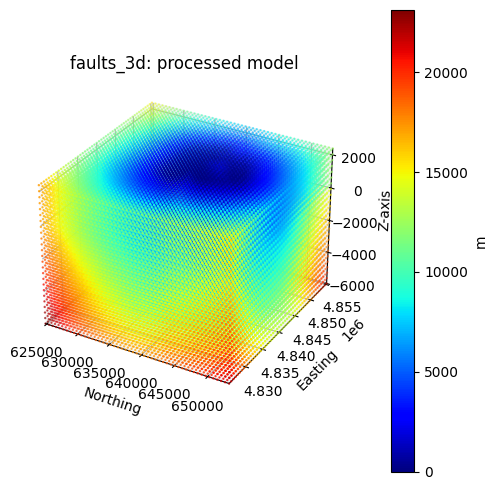

	insulation
		⚠️ Skipping density_joint_inv: no processed 'model' found (likely not interpolated).
		⚠️ Skipping mt_resistivity_joint_inv: no processed 'model' found (likely not interpolated).
		⚠️ Skipping velocity_model_vp: no processed 'model' found (likely not interpolated).

✅ Finished plotting all available processed layers.


In [18]:
# Some layers may not have 'model' entries if interpolation or a processing step was skipped.
# These layers will be skipped automatically with a note to the user.

for criteria, crit_data in pfa["criteria"].items():
    print(criteria)
    plotted_layers = []

    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")

        for layer, layer_data in comp_data["layers"].items():
            if layer in plotted_layers:
                continue

            # Skip if no processed model exists
            if "model" not in layer_data or layer_data["model"] is None:
                print(f"\t\t⚠️ Skipping {layer}: no processed 'model' found (likely not interpolated).")
                continue

            gdf = layer_data["model"]
            col = layer_data.get("model_data_col")
            units = layer_data.get("model_units", "None")
            title = f"{layer}: processed model"

            # Plot in 3D
            GeospatialDataPlotters.geo_plot_3d(
                gdf, col, units, title, extent=extent, markersize=0.5, figsize=(5, 5)
            )

            plotted_layers.append(layer)

print("\n✅ Finished plotting all available processed layers.")


## Save Processed Layers

Because interpolation and 3D processing are computationally heavy, it’s good practice to save processed data to disk before proceeding.

In [ ]:
for criteria, crit_data in pfa["criteria"].items():
    print(criteria)
    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")
        for layer, layer_data in comp_data["layers"].items():
            gdf = layer_data["model"]
            col = layer_data["model_data_col"]
            units = layer_data["model_units"]

            out_fp = data_dir / criteria / component / f"{layer}_processed.csv"
            gdf.to_csv(out_fp, index=False)
            print(f"\t\tSaved: {out_fp}")

geologic
	heat
		density_joint_inv
		mt_resistivity_joint_inv
		temperature_model_500m
		velocity_model_vp
		velocity_model_vs
		velocity_model_vpvs
		earthquakes
	producibility
		density_joint_inv
		mt_resistivity_joint_inv
		velocity_model_vp
		velocity_model_vs
		velocity_model_vpvs
		earthquakes
		faults_3d
	insulation
		density_joint_inv
		mt_resistivity_joint_inv
		velocity_model_vp
		earthquakes


### Optional: Save a “Clean” PFA Config (no GeoDataFrames)
This would typically serve as the config file for the next step. We provide that file in the supplemental data.

In [ ]:
def drop_geodataframes(data: dict) -> dict:
    """Recursively remove GeoDataFrame objects before saving."""
    clean = {}
    for key, val in data.items():
        if isinstance(val, gpd.GeoDataFrame):
            continue
        elif isinstance(val, dict):
            clean[key] = drop_geodataframes(val)
        else:
            clean[key] = val
    return clean

#  pfa_nodf = drop_geodataframes(pfa)
#  out_json = config_dir / "newberry_superhot_processed_config.json"
#  with open(out_json, "w") as f:
#      json.dump(pfa_nodf, f, indent=4)
#  print(f"Processed PFA configuration saved to: {out_json}")

---

## Next Steps: Layer Combination and Favorability Modeling

This concludes **Notebook 1 – Data Processing with `geoPFA`**.

In this notebook, we:
- Loaded, cleaned, and standardized all input datasets  
- Processed each layer (filtering, interpolation, density, distance, transformations)  
- Saved the resulting **processed layers** to disk

You’re now ready to combine these layers into component and criteria favorability models.

If you skip running this notebook, don’t worry — the **supplementary example data** includes all intermediate processed files.  
You can start directly with **Notebook 2 – Layer Combination and Favorability Modeling**, which loads those preprocessed layers automatically.

---
